# Model description
**Outcome variable**
- price (eth)  

**Explanatory variables**
- collection features (daily): volume, total trades, price max, price min, price 5%  
- last sale: price_last_sale, time_last_sale  
- traits/rarity: (1 categorical variable for each trait), rarity rank  

**Models used**
- OLS
- random forest

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file = "bayc_cleaned.csv"
df = pd.read_csv(f"data/{file}", index_col=0)

In [3]:
df.head()

,project,version,block_date,block_month,block_time,token_id,collection,amount_usd,token_standard,trade_type,...,Mouth_value,Mouth_count,Eyes_value,Eyes_count,Fur_value,Fur_count,Clothes_value,Clothes_count,Earring_value,Earring_count
0,x2y2,v1,2023-01-22,2023-01-01,2023-01-22 00:30:23+00:00,5,Bored Ape Yacht Club,317355.814,erc721,secondary,...,Dumbfounded,505,X Eyes,243,Brown,1370,Bayc T Red,140.0,NaN,NaN
1,opensea,v1,2021-06-21,2021-06-01,2021-06-21 15:56:28+00:00,6,Bored Ape Yacht Club,19761.700,erc721,Single Item Trade: Fixed price,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141.0,NaN,NaN
2,opensea,v1,2021-12-22,2021-12-01,2021-12-22 19:16:09+00:00,6,Bored Ape Yacht Club,251182.890,erc721,Single Item Trade: Fixed price,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141.0,NaN,NaN
3,opensea,v3,2022-07-03,2022-07-01,2022-07-03 16:40:36+00:00,6,Bored Ape Yacht Club,93910.130,erc721,single item trade,...,Bored,2272,Crazy,407,Cream,636,Tweed Suit,141.0,NaN,NaN
4,opensea,v3,2022-10-21,2022-10-01,2022-10-21 00:56:23+00:00,8,Bored Ape Yacht Club,141705.300,erc721,single item trade,...,Bored,2272,Robot,350,Zombie,302,NaN,NaN,Gold Stud,439.0


In [4]:
# missing values
df.isna().sum()

project                    0
version                    0
block_date                 0
block_month                0
block_time                 0
token_id                   0
collection                 0
amount_usd                 0
token_standard             0
trade_type                 0
number_of_items            0
trade_category             0
evt_type                   0
trade_price                0
currency_symbol            0
tx_hash                    0
volume_eth                 0
price_p5_eth               0
price_min_eth              0
price_max_eth              0
last_trade_price        9040
last_trade_time         9040
last_trade_timediff     9040
rarity_rank                0
Background_value           0
Background_count           0
Hat_value               9944
Hat_count               9944
Mouth_value                0
Mouth_count                0
Eyes_value                 0
Eyes_count                 0
Fur_value                  0
Fur_count                  0
Clothes_value 

In [9]:
# define column sets
feature_columns = {
    "base_cols" : ['volume_eth', 'price_p5_eth', 'price_max_eth', 'price_min_eth',
                'rarity_rank'],
    "base_traits" : ['Background_count', 'Mouth_count', 'Eyes_count', 'Fur_count'],
    "extra_traits" : ['Hat_count', 'Clothes_count', 'Earring_count'],
    "last_trade" : ['last_trade_timediff', 'last_trade_price'],
}

In [6]:
def df_to_xy(df, X_cols, y_col):
    
    # fetch variables of interest, drop missing values
    data = df.copy()
    n = len(data)
    data = data.dropna(subset=X_cols+[y_col])
    print(f"Number of observations: {len(data)}/{n}")
    
    X = data[X_cols]
    y = data[y_col]
    
    return X, y

In [14]:
# PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def feature_PCA(df, X_cols, y_col, plot=False):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ])

    X,y = df_to_xy(df,X_cols,y_col)

    X_PCA = pipe.fit_transform(X)

    if plot:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y)
        ax.set_xlabel("PCA0")
        ax.set_ylabel("PCA1")
        ax.set_zlabel("PCA2")
        ax.set_title("PCA space")
        plt.show()

    return X_PCA

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def pred_models(df, X_cols, y_col, models=None):
    
    if models is None:
        models = ['ols', 'rf']

    X,y = df_to_xy(df,X_cols,y_col)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # OLS regression
    if 'ols' in models:
        ols = LinearRegression()
        ols.fit(X_train,y_train)
        ols_pred = ols.predict(X_test)
        ols_mse = mean_squared_error(y_test, ols_pred)
        print(f"OLS MSE: {ols_mse}")

    # Random Forest regression
    if 'rf' in models:
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train, y_train)
        rf_predictions = rf.predict(X_test)
        rf_mse = mean_squared_error(y_test, rf_predictions)
        print(f"Random Forest MSE: {rf_mse}")
    

In [30]:
# model 1
X_cols_1 = feature_columns['base_cols'] + feature_columns['base_traits'] + feature_columns['last_trade']
y_col_1 = "trade_price"

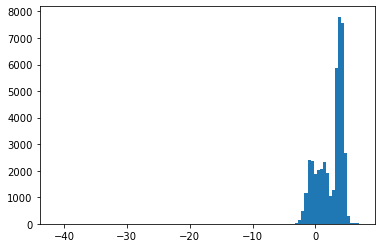

In [33]:
plt.hist(np.log(df['trade_price']),bins=100)
plt.show()

Number of observations: 34362/43402


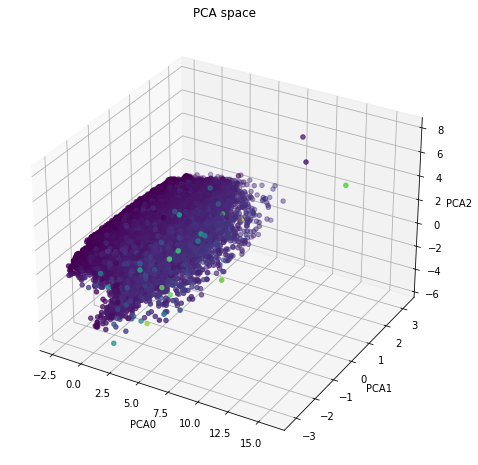

In [31]:
XPCA = feature_PCA(df, X_cols_1, y_col_1, plot=True)

In [32]:
pred_models(df, X_cols_1, y_col_1)

Number of observations: 34362/43402
OLS MSE: 455.777605502643
Random Forest MSE: 220.0790974344981
